<a href="https://colab.research.google.com/github/niku2712/predicting-stock-market-price-using-LSTM/blob/main/Stock_prices_prediction_using_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# importing the required libraries
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM


In [3]:
# importing the Apple stock price dataset from 2015 - 2020
df = pd.read_csv("/content/drive/MyDrive/AAPL.csv")
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [4]:
# now we will clean the data and drop the unnecessary columns
df = df.drop(df.columns[[0,1]],axis = 1)
df.drop(['splitFactor'],axis = 1, inplace = True)


In [5]:
#now let us check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1258 non-null   object 
 1   close      1258 non-null   float64
 2   high       1258 non-null   float64
 3   low        1258 non-null   float64
 4   open       1258 non-null   float64
 5   volume     1258 non-null   int64  
 6   adjClose   1258 non-null   float64
 7   adjHigh    1258 non-null   float64
 8   adjLow     1258 non-null   float64
 9   adjOpen    1258 non-null   float64
 10  adjVolume  1258 non-null   int64  
 11  divCash    1258 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 118.1+ KB


In [6]:
# now we will change the date format of date feature in the file
df.date = pd.to_datetime(df.date)
# as we dont want the time information in date column we will change the formart of date column
df.date = df.date.dt.date
df.head() # to check the head columns of the date

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash
0,2015-05-27,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0
1,2015-05-28,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0
2,2015-05-29,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0
3,2015-06-01,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0
4,2015-06-02,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0


In [7]:
# now let us check if there is an missing value in the date
df.isnull().sum()

date         0
close        0
high         0
low          0
open         0
volume       0
adjClose     0
adjHigh      0
adjLow       0
adjOpen      0
adjVolume    0
divCash      0
dtype: int64

In [8]:
# here we will make the date column as index of our date
df = df.set_index('date')
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash
date,,,,,,,,,,,
2015-05-27,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0
2015-05-28,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0
2015-05-29,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0
2015-06-01,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0
2015-06-02,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0


Text(0.5, 1.0, 'Closing price of Apple stocks from 2015 - 2020')

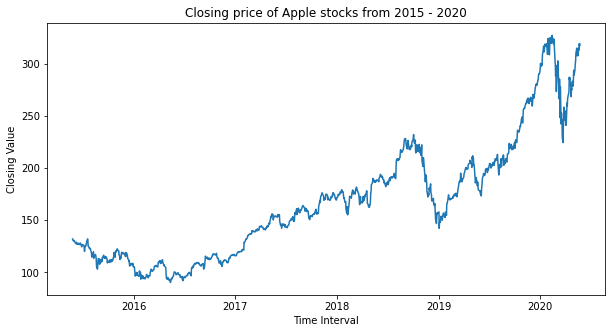

In [9]:
# now let us plot the closing value and the trading volume movement over several years
plt.figure(figsize = (10,5))
df.close.plot()
plt.ylabel('Closing Value')
plt.xlabel('Time Interval')
plt.title('Closing price of Apple stocks from 2015 - 2020' )


Text(0.5, 1.0, 'Sales volume of Apple stocks from 2015 - 2020')

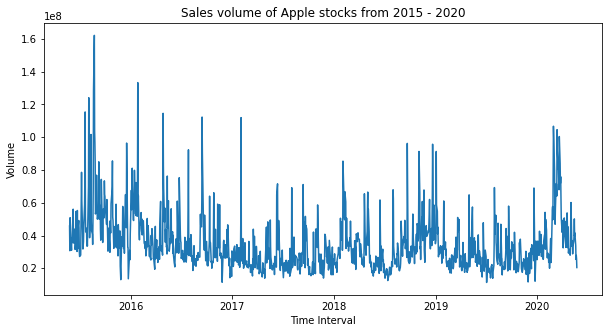

In [10]:
# now let us plot the trading volume movement over several years
plt.figure(figsize = (10,5))
df.volume.plot()
plt.ylabel('Volume')
plt.xlabel('Time Interval')
plt.title('Sales volume of Apple stocks from 2015 - 2020' )

In [11]:
# converting the series data into a supervised format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # now we will input the sequence(t-n, .....t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names +=[('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecasting the sequence (t, t-1, ....t+1)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i ==0:
      names +=[('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names +=[('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # Putting it all together
  agg = concat(cols, axis = 1)
  agg.columns = names
  # now we will drop the rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
    return agg





In [12]:
values = df.values
values = values.astype('float32')

In [13]:
values

array([[1.3204500e+02, 1.3225999e+02, 1.3005000e+02, ..., 1.2011136e+02,
        4.5833248e+07, 0.0000000e+00],
       [1.3178000e+02, 1.3195000e+02, 1.3110001e+02, ..., 1.2151208e+02,
        3.0733308e+07, 0.0000000e+00],
       [1.3028000e+02, 1.3145000e+02, 1.2989999e+02, ..., 1.2093152e+02,
        5.0884452e+07, 0.0000000e+00],
       ...,
       [3.1923001e+02, 3.1951999e+02, 3.1620001e+02, ..., 3.1667999e+02,
        2.7876216e+07, 0.0000000e+00],
       [3.1685001e+02, 3.2089001e+02, 3.1587000e+02, ..., 3.1866000e+02,
        2.5672212e+07, 0.0000000e+00],
       [3.1889001e+02, 3.1923001e+02, 3.1535001e+02, ..., 3.1576999e+02,
        2.0450754e+07, 0.0000000e+00]], dtype=float32)

In [14]:
# let us normalize the data using scaler = MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(values)

# framing as supervised learning
df_new = series_to_supervised(scaled, 1, 1)
print(df_new.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.176074   0.171860   0.173508   0.171857   0.228522   0.152158   
2   0.174956   0.170548   0.177997   0.178333   0.128419   0.151146   
3   0.168623   0.168431   0.172866   0.175649   0.262008   0.145419   
4   0.169699   0.168177   0.173508   0.175521   0.137564   0.146393   
5   0.167272   0.165065   0.170387   0.169812   0.147872   0.144198   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var2(t)   var3(t)  \
1   0.148554   0.149806   0.148290    0.228522  ...  0.170548  0.177997   
2   0.147365   0.153865   0.154145    0.128419  ...  0.168431  0.172866   
3   0.145446   0.149226   0.151718    0.262008  ...  0.168177  0.173508   
4   0.145216   0.149806   0.151603    0.137564  ...  0.165065  0.170387   
5   0.142396   0.146984   0.146441    0.147872  ...  0.166272  0.172866   

    var4(t)   var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  \
1  0.178333  0.128419  0.151146  0.147365  0.15

In [15]:
# we will drop the rest of the columns as we are going to use only the closed price
df_new.drop(df_new.columns[[12, 13, 14, 15, 16, 17, 18, 19, 20, 21]], axis = 1, inplace = True)
print(df_new.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.176074   0.171860   0.173508   0.171857   0.228522   0.152158   
2   0.174956   0.170548   0.177997   0.178333   0.128419   0.151146   
3   0.168623   0.168431   0.172866   0.175649   0.262008   0.145419   
4   0.169699   0.168177   0.173508   0.175521   0.137564   0.146393   
5   0.167272   0.165065   0.170387   0.169812   0.147872   0.144198   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)   var1(t)  
1   0.148554   0.149806   0.148290    0.228522         0.0  0.174956  
2   0.147365   0.153865   0.154145    0.128419         0.0  0.168623  
3   0.145446   0.149226   0.151718    0.262008         0.0  0.169699  
4   0.145216   0.149806   0.151603    0.137564         0.0  0.167272  
5   0.142396   0.146984   0.146441    0.147872         0.0  0.167947  


In [16]:
df_new.shape

(1257, 12)

In [17]:
# splitting the data into train and test sets
values = df_new.values
n_train_days = 365 * 2 # here we are taking last two years of data as training set
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# splitting values into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshaping input to be 3D[sampling, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(730, 1, 11) (730,) (527, 1, 11) (527,)


In [18]:
# creating LSTM model for predicting the stock prices
# designing network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam')

Epoch 1/50
11/11 - 5s - loss: 0.1393 - val_loss: 0.4441 - 5s/epoch - 446ms/step
Epoch 2/50
11/11 - 0s - loss: 0.0882 - val_loss: 0.3261 - 96ms/epoch - 9ms/step
Epoch 3/50
11/11 - 0s - loss: 0.0655 - val_loss: 0.2203 - 86ms/epoch - 8ms/step
Epoch 4/50
11/11 - 0s - loss: 0.0588 - val_loss: 0.1297 - 91ms/epoch - 8ms/step
Epoch 5/50
11/11 - 0s - loss: 0.0570 - val_loss: 0.0763 - 88ms/epoch - 8ms/step
Epoch 6/50
11/11 - 0s - loss: 0.0519 - val_loss: 0.0608 - 81ms/epoch - 7ms/step
Epoch 7/50
11/11 - 0s - loss: 0.0373 - val_loss: 0.0257 - 89ms/epoch - 8ms/step
Epoch 8/50
11/11 - 0s - loss: 0.0259 - val_loss: 0.0263 - 95ms/epoch - 9ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0170 - val_loss: 0.0568 - 86ms/epoch - 8ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0157 - val_loss: 0.0744 - 98ms/epoch - 9ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0160 - val_loss: 0.0785 - 100ms/epoch - 9ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0157 - val_loss: 0.0570 - 82ms/epoch - 7ms/step
Epoch 13/50
11/11 - 0s - loss: 0.015

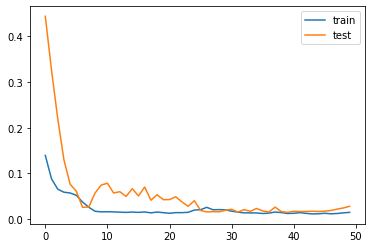

In [19]:
# fitting the network
history = model.fit(train_X, train_y, epochs = 50, batch_size = 72, validation_data = (test_X, test_y), verbose = 2, shuffle = False)
# plotting the history
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [20]:
from keras.layers.serialization import reshaping
# now we need to make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert the scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# inverting scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculating RSME
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RSME: %.3f' % rmse)





17/17 [==============================] - 1s 3ms/step
Test RSME: 9.070


In [21]:
# now let us see the result
result_comp = pd.DataFrame(list(zip(inv_y, inv_yhat)), columns = ['Close_Price_Real', 'Close_Price_Forecast'])
result_comp.head()

,Close_Price_Real,Close_Price_Forecast
0,165.720001,171.635590
1,165.240005,166.614700
2,162.940002,163.754044
3,163.649994,162.068939
4,164.220001,161.518204


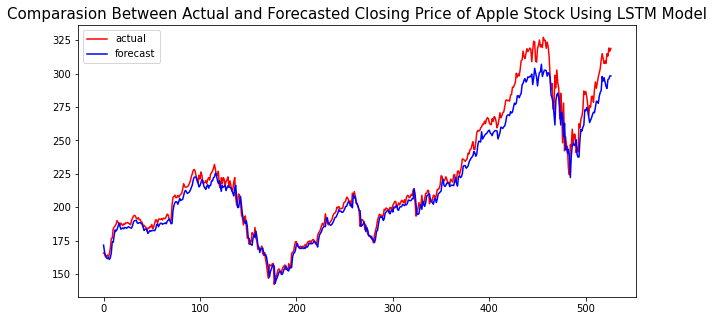

In [22]:
plt.figure(figsize=(10,5))
plt.plot(result_comp['Close_Price_Real'],label='actual',color='red')
plt.plot(result_comp['Close_Price_Forecast'],label='forecast',color='blue')
plt.title('Comparasion Between Actual and Forecasted Closing Price of Apple Stock Using LSTM Model',fontsize=15)
plt.legend()

In [23]:
model.save('_Stock_Price_LSTM.h5')
print("Saved")

Saved


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             12400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32,651
Trainable params: 32,651
Non-trainable params: 0
_________________________________________________________________


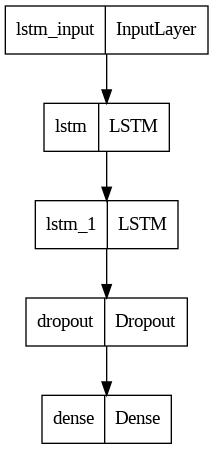

In [26]:
# plotting the model 
from tensorflow import keras
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)